# BlazeFace Inference Tutorial

In [48]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [49]:
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import cv2
from imageio import imread	
import numpy as np
from matplotlib import pyplot as plt

from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from mtcnn import MTCNN

%matplotlib inline

In [50]:
# Set the image size.
img_height = 256
img_width = 256

In [51]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.
select_keypoint = [9,11,13,14,19, 21,23,24,25,26]
output_index = []
for i in select_keypoint:
    output_index.append(i*2-2)
    output_index.append(i*2-1)
model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                normalize_coords=True,
                subtract_mean=[107, 105, 109],
                swap_channels=[2, 1, 0],
                feature=len(output_index))

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/DB_Set2_with_general_glasses_Avg_2Layer_epoch-78_loss-0.0298.h5'

model.load_weights(weights_path, by_name=True)


In [52]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_channel_swap (Lambda)     (None, 256, 256, 3)  0           input_mean_normalization[0][0]   
____________________________________________________________________________________________

Or

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [53]:
import random
import pandas as pd
df = pd.read_csv('/data/tsmoon_set/train_setting_2.csv')

In [54]:
imgs = csv.img_path.tolist()
test_image_name = random.choice(imgs)
# test_image_name = 'Foreigner_Male_1/20200902_day_shadow_01/Class_3/frame/2_20200902_day_shadow_01/2_20200902_day_shadow_01_20 02.jpg'
print(test_image_name)
x = csv[csv.img_path == test_image_name]
xmin, ymin, xmax, ymax = int(x.xmin), int(x.ymin), int(x.xmax), int(x.ymax)
w = xmax - xmin
h = ymax - ymin
cx = int(xmin + w//2)
cy = int(ymin + h//2)
xmin = cx - 128
ymin = cy - 128
xmax = cx + 128
ymax = cy + 128
print(x.iloc[:,1:5])
print(f"xmin,ymin,xmax, ymax: {xmin},{ymin},{xmax},{ymax}")

Foreigner_Female_1/20200915_night_light_01/Class_2/frame/1_20200915_night_light_01_17 09.jpg
       xmin  ymin  xmax  ymax
15391   333   201   504   424
xmin,ymin,xmax, ymax: 290,184,546,440


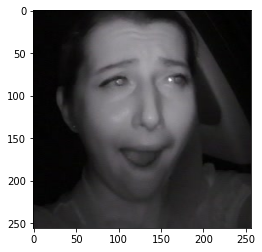

In [56]:
crop_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.
imgs = csv.img_path.tolist()
# test_image_name = random.choice(imgs)
# We'll only load one image in this example.
img_path = f'/data/{test_image_name}'
# img_path = './test/2.jpg'
# detector = MTCNN()
ori_image = cv2.imread(img_path)
ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
ori_image = ori_image[ymin:ymax, xmin:xmax]

# ori_image = cv2.resize(ori_image, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
input_images = np.array([ori_image])
plt.imshow(ori_image)
plt.show()

## 3. Make predictions

In [57]:
from time import time

start = time()
y_pred = model.predict(input_images)
print(time() - start)

1.2110397815704346


In [58]:
anchor = np.array([ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != ''])
anchor = anchor[output_index]
box = np.add(y_pred[0][0], anchor).astype(int)

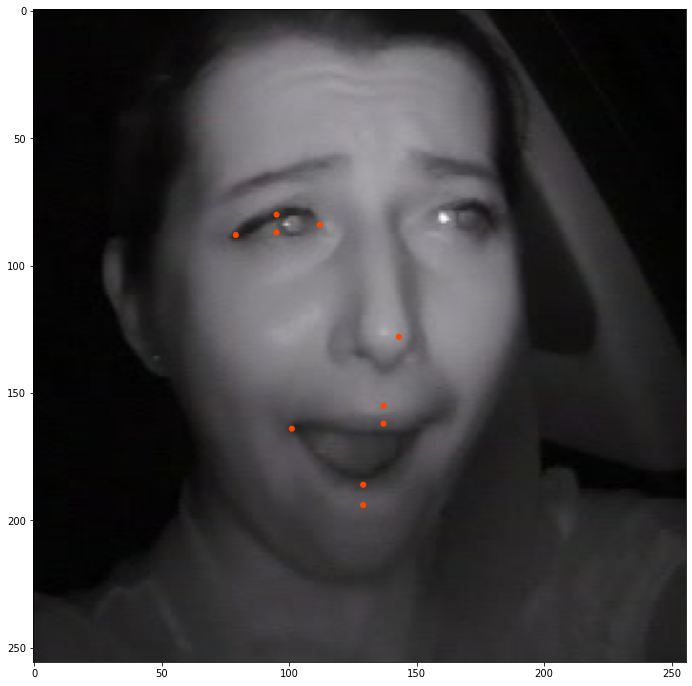

In [59]:

colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(input_images[0])

current_axis = plt.gca()
height, width, _ = input_images[0].shape

for a in range(0, len(box), 2):
    current_axis.add_patch(plt.Circle((box[a], box[a+1]), 1, color=colors[1]))


## MTCNN


In [42]:
import random
import pandas as pd
df = pd.read_csv('/data/tsmoon_set/train_setting_2.csv')

In [43]:
for i in range(len(df)):
    if 'Foreigner_Female_1' not in df.img_path.get(i).split('/')[0] or 'Class_2' not in df.img_path.get(i).split('/')[2]:
        df = df.drop(i)

In [47]:

def mtcnn_bbox(img_path):
    detector = MTCNN()
    ori_image = cv2.imread(img_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    res = detector.detect_faces(ori_image)
    return res

SyntaxError: invalid syntax (<ipython-input-47-816d69ebb474>, line 1)

In [46]:
select_keypoint = [9, 11, 13, 14, 21, 23, 24, 25, 26]
import PIL.Image as Image
from os.path import basename
output_index = []
for i in select_keypoint:
    output_index.append(i*2-2)
    output_index.append(i*2-1)
anchor = np.array([ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != ''])

anchor = anchor[output_index]
for i in range(len(csv)):
    x = csv.iloc[i]

    img_path = f'/data/{x.img_path}'
    # img_path = './test/2.jpg'
    detector = MTCNN()
    ori_image = cv2.imread(img_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)

    res = detector.detect_faces(ori_image)
    if res != []:

        bbox = res[0]['box']
        cx = bbox[0] + bbox[2]//2
        cy = bbox[1] + bbox[3]//2
        xmin = cx - 128
        ymin = cy - 128
        xmax = cx + 128
        ymax = cy + 128
        ori_image = Image.fromarray(ori_image)
        crop_image = ori_image.crop((xmin,ymin,xmax,ymax))
        crop_image = np.array(crop_image)
#         crop_image = ori_image[ymin:ymax, xmin:xmax]
        
#         crop_image = cv2.resize(crop_image, dsize=(256,256), interpolation=cv2.INTER_LINEAR)
        input_images = np.array([crop_image])
        y_pred = model.predict(input_images)

        
        output = np.add(y_pred[0][0], anchor).astype(int)
        
        landmarks = [(int(output[idx]), int(output[idx+1])) for idx in range(0, len(output), 2)]
        for landmark in landmarks:
            cv2.circle(crop_image, landmark, 3, (0, 255, 255), -1)
        cv2.imwrite(f'./test/{basename(x.img_path)}', crop_image)
        
#         for a in range(0, len(box), 2):
#             current_axis.add_patch(plt.Circle((kp[a], kp[a+1]), 1, color=colors[1]))

## Measure 

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.compat.v2.config.experimental.set_memory_growth(gpu, True)
    
import math
import keras
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
import cv2
from imageio import imread	
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from models.keras_blazeface import blazeface
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_DecodeDetections import DecodeDetections

from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from mtcnn import MTCNN
import pandas as pd
from tqdm import tqdm

csv = pd.read_csv('/data/tsmoon_set/valid_with_general_glasses.csv')
img_height = 256
img_width = 256
select_keypoint = [9, 11, 13, 14, 19, 21, 23, 24, 25, 26]

output_index = []
for i in select_keypoint:
    output_index.append(i*2-2)
    output_index.append(i*2-1)
new_output_index = []

for i in output_index:
    new_output_index.append(i+5)
    
anchor = np.array([ float(x) for x in open('anchor_256_fix.txt').readline().split(',') if x != ''])
anchor = anchor[output_index]

K.clear_session() # Clear previous models from memory.

model = blazeface(image_size=(img_height, img_width, 3),
                n_classes=1,
                mode='inference',
                normalize_coords=True,
                subtract_mean=[107, 105, 109],
                swap_channels=[2, 1, 0],
                feature=len(output_index))

# 2: Load the trained weights into the model.

# TODO: Set the path of the trained weights.
weights_path = 'checkpoint/DB_Set2_with_general_glasses_Avg_2Layer_epoch-109_loss-0.0292.h5'
# weights_path = 'checkpoint/DB_Set2_with_nose_Avg_2Layer_epoch-158_loss-0.0239.h5'
# colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
model.load_weights(weights_path, by_name=True)
all_errors = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
count = 0
detector = MTCNN()
for i in tqdm(range(len(csv))):
    
    x = csv.iloc[i]
    if '_1'in x.img_path.split('/')[1]:
        print(X.img_path)
        continue
    
    img_path = f'/data/{x.img_path}'
    
    ori_image = cv2.imread(img_path)
    ori_image = cv2.cvtColor(ori_image, cv2.COLOR_BGR2RGB)
    ori_annos = list(map(int,x[new_output_index].tolist()))   
    
    for i in range(0, len(new_output_index), 2):
        ori_annos[i] += int(x.xmin)
        ori_annos[i+1] += int(x.ymin)
    
#     plt.figure(figsize=(20,12))
#     plt.imshow(ori_image)
    res = detector.detect_faces(ori_image)
    if res != []:

        bbox = res[0]['box']
        cx = bbox[0] + bbox[2]//2
        cy = bbox[1] + bbox[3]//2
        xmin = cx - 128
        ymin = cy - 128
        xmax = cx + 128
        ymax = cy + 128
        ori_image = Image.fromarray(ori_image)
        crop_image = ori_image.crop((xmin,ymin,xmax,ymax))
        crop_image = np.array(crop_image)
        input_images = np.array([crop_image])
        y_pred = model.predict(input_images)

        count +=1
        output = np.add(y_pred[0][0], anchor).astype(int)
        
        landmarks = [[int(output[idx])+xmin, int(output[idx+1])+ymin] for idx in range(0, len(output), 2)]
        landmarks = [y for x in landmarks for y in x]
        distans = lambda x1, y1, x2, y2 : math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        errors = [distans(ori_annos[idx],ori_annos[idx+1],landmarks[idx],landmarks[idx+1])  for idx in range(0, len(landmarks), 2)]
        all_errors = [ x+y for x,y in zip(all_errors, errors)]

for i in all_errors:        
    print(i/len(count))
#         current_axis = plt.gca()
#         for a in range(0, len(box), 2):
#             current_axis.add_patch(plt.Circle((landmarks[a], landmarks[a+1]), 1, color=colors[1]))
#         for a in range(0, len(box), 2):
#             current_axis.add_patch(plt.Circle((ori_annos[a], ori_annos[a+1]), 1, color=colors[10]))

    

Using TensorFlow backend.
 76%|███████▌  | 5389/7086 [11:13<03:39,  7.71it/s]